# FINAL PROJECT - DEEP LEARNING PROJECT - “Spam/Ham messages detection and filtering” - BILSTM


## Preliminary steps

### Preliminary step 1: General Setup 

In [ ]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras-tuner 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import re
import string
import numpy as np
import tensorflow as tf
import seaborn as sns

from  matplotlib import pyplot as plt

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model
from keras_tuner.tuners import RandomSearch

from sklearn.feature_extraction import _stop_words
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

### Preliminary step 2: Connection with Google Drive for upload our dataset 


In [ ]:
"""
Authenticate and create the PyDrive client
"""
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Project steps

### Step 1: Collecting data (Data acquisition)

In [ ]:
df = pd.read_csv("drive/MyDrive/final_report_deeplearnig_PRDL_MLLB/progetto_nostro/spam_dataset.csv")
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

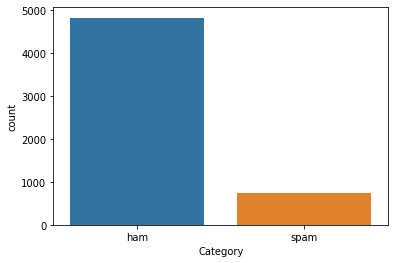

In [ ]:
sns.countplot(x=df['Category'])

### Step 2-3: Preparing the data (Data pre-processing) + Building datasets (Data splitting and balancing)

#### **Cleaning the Raw Data and splitting**

In [ ]:
# Some auxiliary functions:

def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def to_lower(word):
    result = word.lower()
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')

def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for i in cleaning_utils:
        sentence = i(sentence)
    return sentence

In [ ]:
emails_train, emails_test, target_train, target_test = train_test_split(df['Message'],df['Category'], test_size = 0.2) 

x_train = [clean_up_pipeline(i) for i in emails_train]
x_test = [clean_up_pipeline(i) for i in emails_test]

In [ ]:
print(emails_train.shape) #series 
print(emails_train.tolist()[0])

(4457,)
Alrite jod hows the revision goin? Keris bin doin a smidgin. N e way u wanna cum over after college?xx


In [ ]:
print(len(x_train))#list
print(x_train[0])

4457
alrite jod hows the revision goin keris bin doin a smidgin n e way u wanna cum over after collegexx


#### **Tokenizing the Cleaned Data**

In [ ]:
## some config values 
EMBED_SIZE = 100 # how big is each word vector
MAX_FEATURE = 50000 # how many unique words to use (i.e num rows in embedding vector)
MAX_LEN = 2000 # max number of words in a question to use

In [ ]:
tokenizer = Tokenizer(num_words=MAX_FEATURE)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

<ipython-input-19-cba33ecdbf48>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
<ipython-input-19-cba33ecdbf48>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test_features = np.array(tokenizer.texts_to_sequences(x_test))


In [ ]:
x_train_features[0]

[1159,
 3490,
 281,
 5,
 2340,
 473,
 3491,
 1520,
 943,
 4,
 3492,
 89,
 167,
 129,
 6,
 314,
 749,
 194,
 145,
 3493]

#### **Text Sequencing: Padding**

In [ ]:
x_train_features = pad_sequences(x_train_features,maxlen=MAX_LEN)
x_test_features = pad_sequences(x_test_features,maxlen=MAX_LEN)


In [ ]:
x_train_features[0]

array([   0,    0,    0, ...,  194,  145, 3493], dtype=int32)

In [ ]:
x_test_features[0]

array([  0,   0,   0, ...,  18,  13, 355], dtype=int32)

#### **Label the encoding target variable**

In [ ]:
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.fit_transform(target_test.values)

### Step 4: Choosing the best model (Model building)

In [ ]:
# create the model
EMBEDDING_VECTOR_LENGTH = 32

model = tf.keras.Sequential()
model.add(Embedding(MAX_FEATURE, EMBEDDING_VECTOR_LENGTH, input_length=MAX_LEN))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 32)          1600000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
______________________________________________

### Step 5: Training the model (Model training)



In [ ]:
history = model.fit(x_train_features, train_y, batch_size=32, epochs=5, validation_data=(x_test_features, test_y))

Epoch 1/5
140/140 [==============================] - 296s 2s/step - loss: 0.2565 - accuracy: 0.9179 - val_loss: 0.0787 - val_accuracy: 0.9749
Epoch 2/5
140/140 [==============================] - 291s 2s/step - loss: 0.0465 - accuracy: 0.9881 - val_loss: 0.0552 - val_accuracy: 0.9865
Epoch 3/5
140/140 [==============================] - 291s 2s/step - loss: 0.0236 - accuracy: 0.9939 - val_loss: 0.0552 - val_accuracy: 0.9839
Epoch 4/5
140/140 [==============================] - 291s 2s/step - loss: 0.0110 - accuracy: 0.9971 - val_loss: 0.0579 - val_accuracy: 0.9865
Epoch 5/5
140/140 [==============================] - 290s 2s/step - loss: 0.0061 - accuracy: 0.9987 - val_loss: 0.0545 - val_accuracy: 0.9857


### Step 6: Testing & Evaluating the model (Performance evaluation)


In [ ]:
y_predicted = model.predict(x_test_features)
y_predicted = y_predicted.flatten()

35/35 [==============================] - 13s 342ms/step


In [ ]:
y_predicted 

array([1.26552628e-03, 6.46047120e-05, 1.05286614e-04, ...,
       8.18684883e-03, 1.48238643e-04, 2.97678239e-03], dtype=float32)

In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)


In [ ]:
cf_matrix =confusion_matrix(test_y,y_predicted)

tn, fp, fn, tp = confusion_matrix(test_y,y_predicted).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predicted)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predicted)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predicted)))

f1_score(test_y,y_predicted)

Precision: 97.18%
Recall: 92.00%
F1 Score: 94.52%


0.9452054794520549

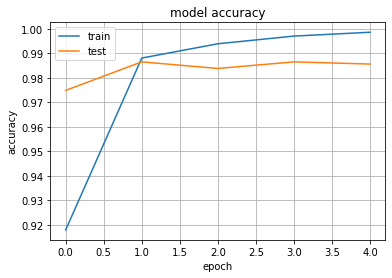

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

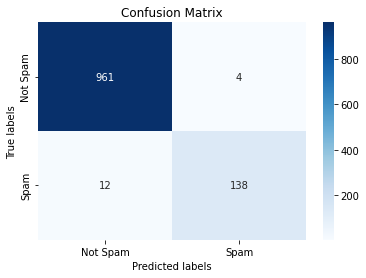

In [ ]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);



### Step 7: Performing Hyperparameters Tuning 



In [ ]:
def build_model(hp):
  model = tf.keras.Sequential()
  model.add(Embedding(MAX_FEATURE, EMBEDDING_VECTOR_LENGTH, input_length=MAX_LEN))
  model.add(Bidirectional(tf.keras.layers.LSTM(64)))
  model.add(Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(
       optimizer=keras.optimizers.Adam(
           hp.Choice ('learning_rate',
                      values=[0.01, 0.0001])),
                loss='binary_crossentropy',
                 metrics=['accuracy'])
  return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 3,
    executions_per_trial = 2,
    overwrite = True 
    )

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}


In [ ]:
tuner.search(x_train_features, train_y, epochs=5, validation_data=(x_test_features, test_y))

Trial 3 Complete [00h 50m 14s]
val_accuracy: 0.9847533702850342

Best val_accuracy So Far: 0.9847533702850342
Total elapsed time: 02h 29m 15s


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 16
learning_rate: 0.01
Score: 0.9847533702850342
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.0001
Score: 0.9793722033500671
Trial summary
Hyperparameters:
units: 16
learning_rate: 0.0001
Score: 0.9735426008701324


### Step 8: Interpreting the model results (Deployment)

In [ ]:
def get_predictions(text):
  sequence = tokenizer.texts_to_sequences([text])
  # pad the sequence
  sequence = pad_sequences(sequence, maxlen=MAX_LEN)
  # get the prediction
  prediction = model.predict(sequence)[0]

  return prediction

In [ ]:
messages = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]

for i in range(len(messages)):
  text = messages[i]
  print(text)
  pred = get_predictions(text)
  print(pred)
  if pred[0] >= 0.5:
    print("ALERT: It's a SPAM message!!!")
  else:
    print("It's a HAM message")
  print("\n")

Enter a chance to win $5000, hurry up, offer valid until march 31, 2021
1/1 [==============================] - 0s 332ms/step
[0.9980209]
ALERT: It's a SPAM message!!!


You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99
1/1 [==============================] - 0s 131ms/step
[0.9999237]
ALERT: It's a SPAM message!!!


it to 80488. Your 500 free text messages are valid until 31 December 2005.
1/1 [==============================] - 0s 124ms/step
[0.9986316]
ALERT: It's a SPAM message!!!


Hey Sam, Are you coming for a cricket game tomorrow
1/1 [==============================] - 0s 170ms/step
[0.0003728]
It's a HAM message


Why don't you wait 'til at least wednesday to see if you get your .
1/1 [==============================] - 0s 201ms/step
[0.00043236]
It's a HAM message


